In [1]:
%load_ext autoreload
%autoreload 2

## Initial Code Setup

In [2]:
#Import Packages
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

import os

from itertools import count
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#Import custom classes
from Source.NN_model_2 import QNetwork
from Source.dqn_agent_2 import Agent, ReplayBuffer, EpsilonGreedyStrategy
from Source.Env_Manager import EnvManager
from Source.Misc import plot

import tqdm
from tqdm import tnrange, tqdm_notebook
from time import sleep
from datetime import date

In [3]:
#Hyper-parameters
BUFFER_SIZE = int(1e5)      #replay buffer size
BATCH_SIZE = 60             #minibatch size
GAMMA = 0.999                #discount factor
LR = 5e-4                   #learning rate
UPDATE_EVERY = 50            #how often to update the network
EPISODE_REPEAT = 300            #no. of simulations performed on each episode  
SEED = 0                    #random seed number

TAU = 1e-3                  #for soft update of target parameters
EPS_START = 1
EPS_END = 0.01
EPS_DECAY = 0.9983 #125e-6
EPISODE_STEP_LIMIT = 50
TRAIN_EPISODES = 2800
TEST_EPISODES = 20

#Choose the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



def Initialize_Setup():
    #Choose the environment
    em = EnvManager(device, 'uav-v3', SEED)
    available_actions = em.num_actions_available()
    random.seed(SEED)

    #Select the strategy
    strategy = EpsilonGreedyStrategy(EPS_START, EPS_END, EPS_DECAY)

    #Initialize the agent
    agent = Agent(strategy, available_actions, SEED, device)

    #Instantiate MemoryBuffer
    memory = ReplayBuffer(available_actions, BUFFER_SIZE, BATCH_SIZE, SEED, device)

    policy_net = QNetwork(available_actions, SEED).to(device)
    target_net = QNetwork(available_actions, SEED).to(device)
    #print(policy_net)

    #Initialize target_net weights to policy_net weights
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval() #Set the target_net in eval mode

    #Select the optimizer
    optimizer = optim.Adam(params=policy_net.parameters(), lr=LR)
    return em, strategy, agent, memory, policy_net, target_net, optimizer

em, strategy, agent, memory, policy_net, target_net, optimizer = Initialize_Setup()
measure = 'rate_thr_path'

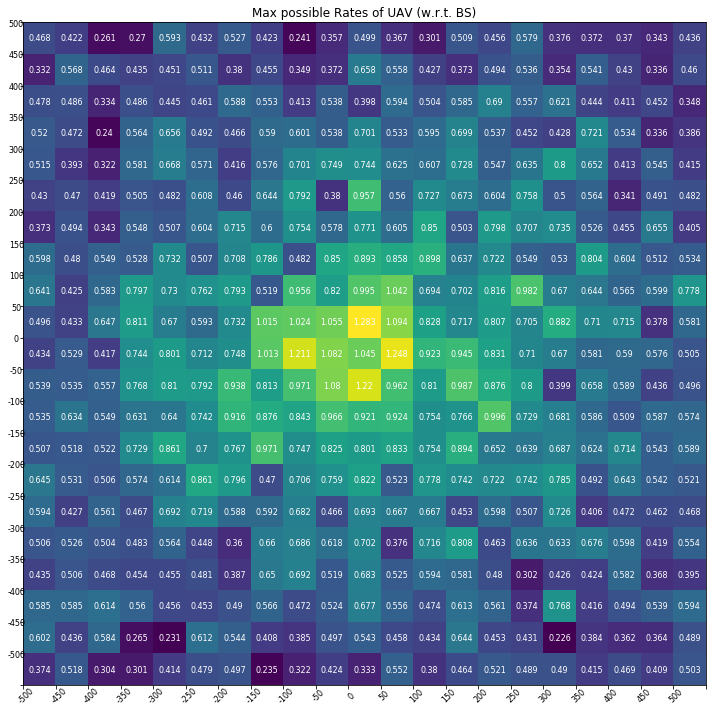

In [4]:
exh_rates_fname = 'env_exh_rates.txt'
ue_xloc = em.env.ue_xloc  #20 locs
ue_yloc = em.env.ue_yloc[::-1]     #20 locs

if os.path.exists(exh_rates_fname):
    rate_arr = np.loadtxt(exh_rates_fname, dtype=float)
else:
    # File is empty
    rate_tr = 0.0
    t_step = 0

    rate_arr = np.zeros([(max(ue_yloc)-min(ue_yloc))//50 +1, (max(ue_xloc)-min(ue_xloc))//50 + 1]) #(-500,50) -----> (500,500)
    for y_ndx in range(len(ue_yloc)):
        for x_ndx in range(len(ue_xloc)):
            state = np.array([ue_xloc[x_ndx], ue_yloc[y_ndx]])/ em.env.high_obs
            exh_bdir,exh_rate = em.env.get_Exh_Rate(state)
            rate_arr[y_ndx,x_ndx] = np.around(exh_rate, decimals=3)
    np.savetxt(exh_rates_fname, rate_arr, fmt='%f')

row_labels = [str(x) for x in ue_yloc]
col_labels = [str(x) for x in ue_xloc]

fig, ax = plt.subplots(1,1, figsize=(10,10))
im = ax.imshow(rate_arr, aspect='auto')

# We want to show all ticks...
ax.set_xticks(np.arange(rate_arr.shape[1]+1)-.5)
ax.set_yticks(np.arange(rate_arr.shape[0]+1)-.5)
# ... and label them with the respective list entries
ax.set_xticklabels(col_labels, fontsize=8)
ax.set_yticklabels(row_labels, fontsize=8)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="center",
         rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=0, ha="center",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(rate_arr.shape[0]):
    for j in range(rate_arr.shape[1]):
        text = ax.text(j, i, rate_arr[i, j],
                       ha="center", va="center", color="w", fontsize=8)

ax.set_title("Max possible Rates of UAV (w.r.t. BS)")
fig.tight_layout()
plt.show()    



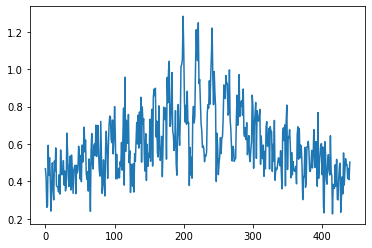

In [5]:
rate_arr = rate_arr.flatten()
#print(rate_arr[160])
plt.plot(rate_arr)
plt.show()

In [6]:
rate_thr_indices = [24, 175, 80, 157, 179, 284]

for i in rate_thr_indices:
    print(rate_arr[i])

0.435
0.519
0.721
0.893
1.042
0.833


In [7]:
def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1).mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

In [8]:
def Training_Loop(policy_net, target_net, memory, em, agent, optimizer, train_episodes, rate_thr, rate_ndx, measure):
    episode_durations = []
    episode_rewards = []
    policy_net.train()

    outer = tqdm.tqdm_notebook(total=train_episodes, desc='{1}: {0}-training loop: '.format(rate_ndx, measure), position=0)

    for episode in range(train_episodes):
        #Set the rate requirement and reset environment
        state_indices = em.env.obs_space.sample()
        state = em.reset(rate_thr, measure, state_indices)
        
        ep_loss, ep_rwd, timestep = 0.0, 0.0, 0

        #Count the steps in agent
        agent.current_step +=1      
        for timestep in count():
            action = agent.act(state, policy_net)    
            next_state, reward, done, _ = em.step(action)
            ep_rwd += reward.item()
            memory.add(state, action, reward, next_state, done)

            state = next_state

            if memory.can_provide_sample():
                experiences = memory.sample()
                states, actions, rewards, next_states, dones = experiences

                current_q_values = policy_net(states).gather(1,index=actions.unsqueeze(-1))
                next_q_values = target_net(next_states).detach().max(1)[0]
                target_q_values = (next_q_values*GAMMA) + rewards

                loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
                ep_loss += loss.item()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if (timestep==EPISODE_STEP_LIMIT) or done:
                episode_durations.append(timestep)
                episode_rewards.append(ep_rwd/(timestep+1))
                print('\rEpisode {}\t timestep: {}, Score: {:.2f}, eps: {}'.format(episode+1, timestep, ep_rwd, agent.strategy.get_exploration_rate(agent.current_step)), end="\r")
                break
                                
        if episode % UPDATE_EVERY == 0:
            target_net.load_state_dict(policy_net.state_dict())
            
        # update tqdm outer progress bar
        outer.update(1)
    torch.save(policy_net.state_dict(), 'model_{0}_150120_{1}.pth'.format(measure, rate_ndx))
    np.savetxt('{0}_rewards_150120_{1}.txt'.format(measure, rate_ndx), np.array(episode_rewards), fmt='%f')
    np.savetxt('{0}_durations_150120_{1}.txt'.format(measure, rate_ndx), np.array(episode_durations), fmt='%f')
    return episode_rewards, episode_durations

## 1. Training over different rate threshold

rate_threshold:  0.435


Episode 2800	 timestep: 10, Score: 3.74, eps: 0.010010561361234933



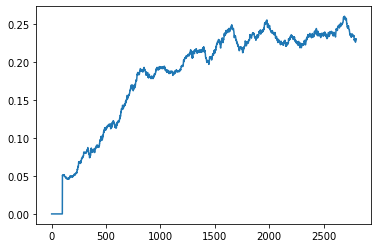

rate_threshold:  0.519


Episode 2800	 timestep: 22, Score: 5.08, eps: 0.010010561361234933



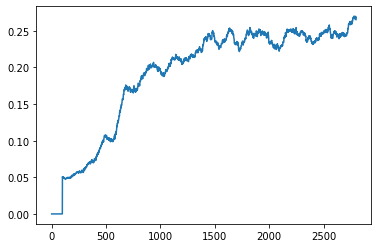

rate_threshold:  0.721


Episode 2800	 timestep: 25, Score: 5.75, eps: 0.010010561361234933



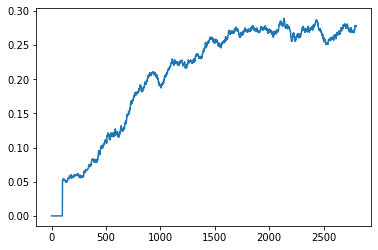

rate_threshold:  0.893


Episode 2800	 timestep: 10, Score: 4.10, eps: 0.010010561361234933



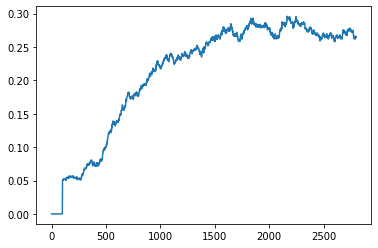

In [9]:
rate_thr_indices = [24, 175, 80, 157]
rate_thr_rwd_fname = 'rate_thr_rewards.txt'
rate_thr_dur_fname = 'rate_thr_durations.txt'
measure = 'rate_thr_path'

rate_thr_episode_rewards = []
rate_thr_episode_durations = []
for rate_ndx in rate_thr_indices:
    print("rate_threshold: ", rate_arr[rate_ndx])
    
    #Re-Initialize Setup
    em, strategy, agent, memory, policy_net, target_net, optimizer = Initialize_Setup()
    rate_thr = rate_arr[rate_ndx]
    
    rate_thr_fname = 'model_' + measure + '_150120_' + str(rate_ndx) + '.pth'
    if os.path.exists(rate_thr_fname):
        episode_rewards = np.loadtxt(measure + '_rewards_150120_' + str(rate_ndx) + '.txt')
        episode_durations = np.loadtxt(measure + '_durations_150120_' + str(rate_ndx) + '.txt')
        episode_rewards = episode_rewards.tolist()
        episode_durations = episode_durations.tolist()
    else:
        #Training Loop
        episode_rewards, episode_durations = Training_Loop(policy_net, target_net, memory,em, agent, optimizer, TRAIN_EPISODES, rate_thr, rate_ndx, measure)
    
    print("\n")
    rate_thr_episode_rewards.append(episode_rewards)
    rate_thr_episode_durations.append(episode_durations)
    moving_avg = get_moving_average(100, episode_rewards)
    plt.plot(moving_avg)
    plt.show()

np.savetxt(rate_thr_rwd_fname, np.array(rate_thr_episode_rewards), fmt='%f')
np.savetxt(rate_thr_dur_fname, np.array(rate_thr_episode_durations), fmt='%f')



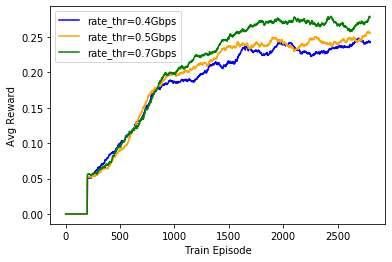

In [10]:
#Plot the figures
rate_thr_rwd_fname = 'rate_thr_rewards.txt'
rate_thr_episode_rewards = np.loadtxt(rate_thr_rwd_fname)
rate_thr = [0.435, 0.519,0.721,0.893]
plt.figure()
plt.clf()
#plt.title('Training...')
plt.xlabel('Train Episode')
plt.ylabel('Avg Reward')
moving_avg_period = 200

moving_avg0 = get_moving_average(moving_avg_period, rate_thr_episode_rewards[0])
plt.plot(moving_avg0, color='blue', label='rate_thr={0}Gbps'.format(np.around(rate_arr[rate_thr_indices[0]], decimals=1)))

moving_avg1 = get_moving_average(moving_avg_period, rate_thr_episode_rewards[1])
plt.plot(moving_avg1, color='orange', label='rate_thr={0}Gbps'.format(np.around(rate_arr[rate_thr_indices[1]], decimals=1)))


moving_avg2 = get_moving_average(moving_avg_period, rate_thr_episode_rewards[2])
plt.plot(moving_avg2, color='green', label='rate_thr={0}Gbps'.format(np.around(rate_arr[rate_thr_indices[2]], decimals=1)))    
plt.legend()
#plt.savefig('rwd_fn_plot_051119.pdf')
plt.show()

## 2. Path plot rate_threshold vs shortest path vs rate path

In [11]:
#rate_threshold path
rate_ndx = 175 #3 Mbps
#Re-Initialize Setup

em, strategy, agent, memory, policy_net, target_net, optimizer = Initialize_Setup()
rate_thr = rate_arr[rate_ndx]
measure = 'rate_thr_path'

rate_thr_fname = 'model_' + measure + '_150120_' + str(rate_ndx) + '.pth'
if os.path.exists(rate_thr_fname):
    rate_thr_episode_rewards = np.loadtxt(measure + '_rewards_150120_' + str(rate_ndx) + '.txt')
    rate_thr_episode_durations = np.loadtxt(measure + '_durations_150120_' + str(rate_ndx) + '.txt')
    rate_thr_episode_rewards = rate_thr_episode_rewards.tolist()
    rate_thr_episode_durations = rate_thr_episode_durations.tolist()
else:
    #Training Loop
    rate_thr_episode_rewards, rate_thr_episode_durations = Training_Loop(policy_net, target_net, memory, em, agent, optimizer, TRAIN_EPISODES, rate_thr, rate_ndx, measure)
    print("\n")
    #rate_thr_path_rates = em.env.ue_path_rates
    #rate_thr_path = em.env.ue_path_rates

#-------------------------------------------------------------------------------------------------------------------------------
#shortest path

#Re-Initialize Setup
em, strategy, agent, memory, policy_net, target_net, optimizer = Initialize_Setup()
rate_thr = rate_arr[rate_ndx]
measure = 'short_path'
#Training Loop
short_episode_rewards, short_episode_durations = Training_Loop(policy_net, target_net, memory, em, agent, optimizer, TRAIN_EPISODES, rate_thr, rate_ndx, measure)
print("\n")
#short_path_rates = em.env.ue_path_rates
#short_path = em.env.ue_path_rates

#------------------------------------------------------------------------------------------------------------------------------
#Rate Path
'''
#Re-Initialize Setup
em, strategy, agent, memory, policy_net, target_net, optimizer = Initialize_Setup()
rate_thr = rate_arr[rate_ndx]
measure = 'rate_path'

#Training Loop
rate_episode_rewards, rate_episode_durations = Training_Loop(policy_net, target_net, memory, em, agent, optimizer, TRAIN_EPISODES, rate_thr, rate_ndx, measure)
print("\n")
rate_path_rates = em.env.ue_path_rates
rate_path = em.env.ue_path_rates
'''

Episode 2800	 timestep: 27, Score: -26.00, eps: 0.011056136123493003



'\n#Re-Initialize Setup\nem, strategy, agent, memory, policy_net, target_net, optimizer = Initialize_Setup()\nrate_thr = rate_arr[rate_ndx]\nmeasure = \'rate_path\'\n\n#Training Loop\nrate_episode_rewards, rate_episode_durations = Training_Loop(policy_net, target_net, memory, em, agent, optimizer, TRAIN_EPISODES, rate_thr, rate_ndx, measure)\nprint("\n")\nrate_path_rates = em.env.ue_path_rates\nrate_path = em.env.ue_path_rates\n'

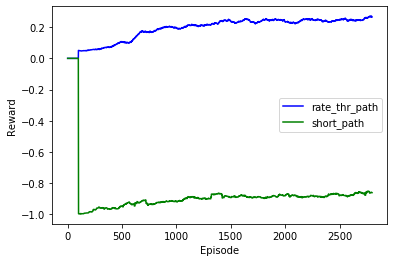

In [12]:
#Plot the figures
plt.figure()
plt.clf()
plt.xlabel('Episode')
plt.ylabel('Reward')
moving_avg_period = 100

moving_avg0 = get_moving_average(moving_avg_period, rate_thr_episode_rewards)
plt.plot(moving_avg0, color='blue', label='rate_thr_path')

#moving_avg1 = get_moving_average(moving_avg_period, rate_episode_rewards)
#plt.plot(moving_avg1, color='orange', label='rate_path')

moving_avg2 = get_moving_average(moving_avg_period, short_episode_rewards)
plt.plot(moving_avg2, color='green', label='short_path')    

plt.legend()
plt.show()

In [13]:
measures=['rate_thr_path', 'short_path']
rate_ndx = 175

#Initialize the setup
em, strategy, agent, memory, policy_net, target_net, optimizer = Initialize_Setup()
src_xndx, src_yndx = em.env.obs_space.sample()

src_loc = np.array([em.env.ue_xloc[src_xndx],em.env.ue_yloc[src_yndx]])
dest_loc = np.array([em.env.ue_xdest[0], em.env.ue_ydest[0]])
gNB_loc = np.array([em.env.gNB[0][0], em.env.gNB[0][1]]) #2D location
ue_paths = []
ue_path_rates=[]
ue_path_exh_rates = []
for meas in measures:
    
    #Initialize the setup
    em, strategy, agent, memory, policy_net, target_net, optimizer = Initialize_Setup()

    #Load the weights from file
    #policy_net.load_state_dict(torch.load('model_{0}_{1}_{2}.pth'.format(meas, date.today().strftime("%d%m%y"), rate_ndx)))
    policy_net.load_state_dict(torch.load('model_{0}_150120_{1}.pth'.format(meas,rate_ndx)))
    
    policy_net.eval()
    
    state_tensor = em.reset(rate_arr[rate_ndx], meas, (src_xndx, src_yndx))
    
    exh_rates = []
    for t_step in count():
        action = policy_net(state_tensor).argmax(dim=1).to(device)
        next_state_tensor, reward, done, _ = em.step(action)
        
        state = np.rint(state_tensor.squeeze().cpu().data.numpy() * em.env.high_obs)
        next_state = np.rint(next_state_tensor.squeeze().cpu().data.numpy() * em.env.high_obs)
        #print("Current State: ", state)
        #print("Next State: ", next_state)
        
        curr_loc = (state[0], state[1])
        next_loc = (next_state[0], next_state[1])
        
        next_state = next_state / em.env.high_obs
        state = state / em.env.high_obs
        
        state_tensor = torch.tensor(np.array([next_state]), dtype=torch.float32).to(device)
        _, exh_rate = em.env.get_Exh_Rate(next_state)
        
        exh_rates.append(exh_rate)
        if (t_step == EPISODE_STEP_LIMIT) or done:
            break
    ue_paths.append(em.env.ue_path)
    ue_path_rates.append(em.env.ue_path_rates)
    ue_path_exh_rates.append(exh_rates)
#print(ue_paths)

rate thr Count: 15, short path count: 15


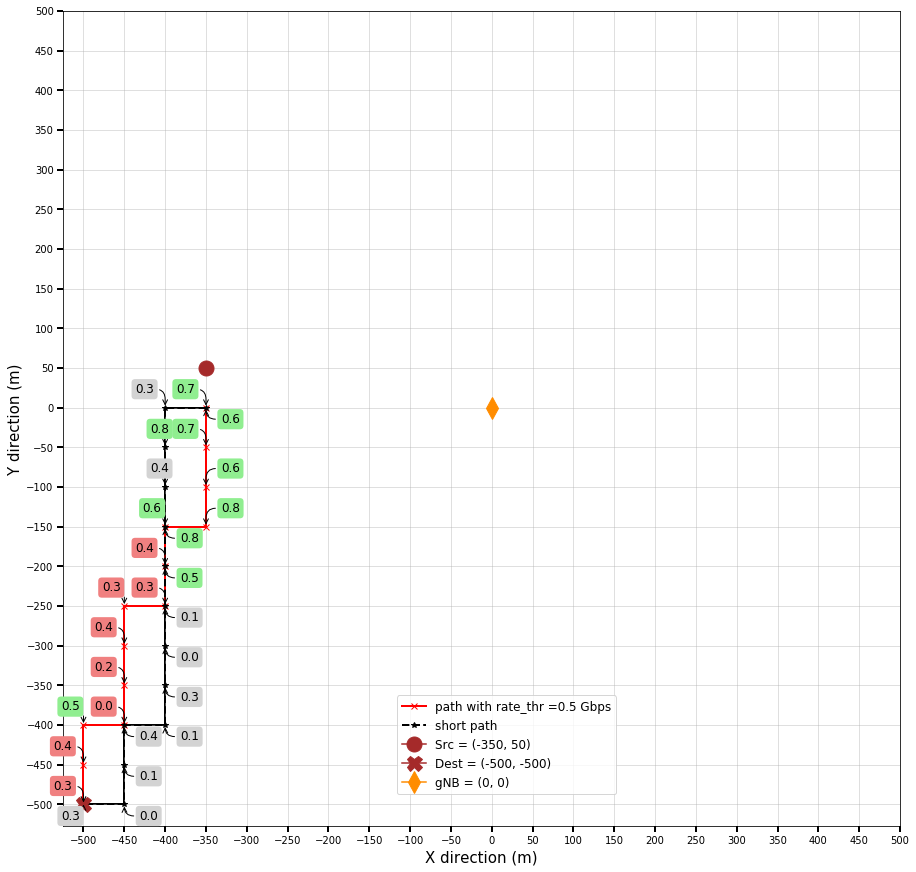

In [14]:
from matplotlib.path import Path
import matplotlib.patches as patches

#rate_thr_path
rate_thr_path = ue_paths[0]
rate_thr_path_rates = ue_path_rates[0]
rate_thr_path_exh_rates = ue_path_exh_rates[0]
rate_thr_verts = [(int(x[0]), int(x[1])) for x in rate_thr_path]
rate_thr_codes = [Path.LINETO for x in range(len(rate_thr_verts))]
rate_thr_codes[0] = Path.MOVETO
rate_thr_codes[-1] = Path.STOP
rate_thr_path  = Path(rate_thr_verts, rate_thr_codes)
rate_ndx = 175
rate_thr = np.around(rate_arr[rate_ndx], decimals=1)

#rate_path
#rate_path = ue_paths[1]
#rate_path_rates = ue_path_rates[1]
#rate_verts = [(int(x[0]), int(x[1])) for x in rate_path]
#rate_codes = [Path.LINETO for x in range(len(rate_verts))]
#rate_codes[0] = Path.MOVETO
#rate_codes[-1] = Path.STOP
#rate_path  = Path(rate_verts, rate_codes)

#short_path
short_path = ue_paths[1]
short_path_rates = ue_path_rates[1]
short_verts = [(int(x[0]), int(x[1])) for x in short_path]
short_codes = [Path.LINETO for x in range(len(short_verts))]
short_codes[0] = Path.MOVETO
short_codes[-1] = Path.STOP
short_path  = Path(short_verts, short_codes)

print("rate thr Count: {}, short path count: {}".format(len(rate_thr_path), len(short_path)))
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
rate_thr_patch = patches.PathPatch(rate_thr_path, facecolor='none', lw=2)
#rate_patch = patches.PathPatch(rate_path, facecolor='none', lw=2)
short_patch = patches.PathPatch(short_path, facecolor='none', lw=2)
ax.add_patch(rate_thr_patch)
#ax.add_patch(rate_patch)
ax.add_patch(short_patch)

rate_thr_xs, rate_thr_ys = zip(*rate_thr_verts)
ax.plot(rate_thr_xs, rate_thr_ys, 'x-', lw=2, color='red', label='path with rate_thr ={} Gbps'.format(rate_thr))

#rate_xs, rate_ys = zip(*rate_verts)
#ax.plot(rate_xs, rate_ys, 'o--', lw=2, color='magenta', label='rate path')

short_xs, short_ys = zip(*short_verts)
ax.plot(short_xs, short_ys, '*--', lw=2, color='black', label='short path')

bbox = dict(boxstyle="round", facecolor='burlywood', edgecolor='none')
arrowprops = dict(
    arrowstyle="->",
    connectionstyle="angle,angleA=0,angleB=90,rad=10")

offset = 50
#Plot src
ax.plot(src_loc[0], src_loc[1], marker='o',markersize=15, color='brown', label='Src = (%d, %d)' % (src_loc[0], src_loc[1]))
#ax.annotate('Src = (%d, %d)' % (src_loc[0], src_loc[1]),
#            (src_loc[0], src_loc[1]), xytext=(-2 * offset, offset), textcoords='offset points',
#            bbox=bbox, arrowprops=arrowprops)

ax.plot(dest_loc[0], dest_loc[1], marker='X',markersize=15, color='brown', label='Dest = (%d, %d)' % (dest_loc[0], dest_loc[1]))
#ax.annotate('Dest = (%d, %d)' % (dest_loc[0], dest_loc[1]),
#                   (dest_loc[0], dest_loc[1]), xytext=(0.5 * offset, -0.25*offset),
#                   textcoords='offset points',
#                   bbox=bbox, arrowprops=arrowprops)

#Plot gNB
bbox = dict(boxstyle="round", facecolor='burlywood', edgecolor='none')
arrowprops1 = dict(
    arrowstyle="->",
    connectionstyle="angle,angleA=0,angleB=135,rad=10")
ax.plot(gNB_loc[0], gNB_loc[1], marker='d', markersize=15, color='darkorange', label='gNB = (%d, %d)' % (gNB_loc[0], gNB_loc[1]))
#ax.annotate('gNB = (%d, %d)' % (gNB_loc[0], gNB_loc[1]),
#                   (gNB_loc[0], gNB_loc[1]), xytext=(-2 * offset, 1*offset),
#                   textcoords='offset points',
#                   bbox=bbox, arrowprops=arrowprops1)



#Annotate rate values on short and proposed rate_thr path 
offset= 15
for i in range(0,len(short_path_rates)-1):
    xytext2 = (-2 * offset, offset)
    
    if (i== (len(short_path_rates)-2)):
        xytext1=(-1.5 * offset, -1*offset)
    elif((short_verts[i][0], short_verts[i][1]) == (rate_thr_verts[i][0], rate_thr_verts[i][1])):
        xytext1=(1 * offset, -1*offset)
    elif (i>0) and (short_verts[i][0] < short_verts[i-1][0]):
        xytext1=(-2 * offset, 1*offset)
    elif(short_verts[i][0] < rate_thr_verts[i][0]):
        xytext1=(-1 * offset, 1*offset)
        xytext2=(1 * offset, 1*offset)
    elif(short_verts[i][0] > rate_thr_verts[i][0]):
        xytext1=(1 * offset, -1*offset)
   
    else:
        xytext1=(-1 * offset, -1*offset)
        
    if (np.around(short_path_rates[i], decimals=1) >= rate_thr):
        facecolor1 = 'lightgreen'
    else:
        facecolor1 = 'lightgrey'
    
    
    if(i>0) and (rate_thr_verts[i][0] < rate_thr_verts[i-1][0]):
        xytext2=(-1.5 * offset, 1*offset)
           
    if (np.around(rate_thr_path_rates[i], decimals=1) >= rate_thr):
        facecolor2 = 'lightgreen'
    else:
        facecolor2 = 'lightcoral'

    bbox1 =dict(boxstyle="round", facecolor=facecolor1, edgecolor='none')
    ax.annotate('{0:.1f}'.format(np.around(short_path_rates[i], decimals=1)) ,
                (short_verts[i][0], short_verts[i][1]), xytext=xytext1, textcoords='offset points',
                bbox=bbox1, arrowprops=arrowprops,size=12)
    
    bbox2 =dict(boxstyle="round", facecolor=facecolor2, edgecolor='none')
    
    ax.annotate('{0:.1f}'.format(np.around(rate_thr_path_rates[i], decimals=1)) ,
                (rate_thr_verts[i][0], rate_thr_verts[i][1]), xytext=xytext2, textcoords='offset points',
                bbox=bbox2, arrowprops=arrowprops,size=12)

ax.grid(alpha=0.5)
ax.set_xticks(em.env.ue_xloc)
ax.set_yticks(em.env.ue_yloc)
ax.tick_params(direction='out', length=6, width=2)
#ax.set_title("UAV graph w.r.t gNB [0,0,0]")
ax.set_xlabel("X direction (m)", fontsize=15)
ax.set_ylabel("Y direction (m)", fontsize=15)
ax.legend(loc='center', bbox_to_anchor=(0.28, -0.15, .5, .5), fontsize='large')
plt.savefig('rate_thr_test_episode_150120.jpeg')
plt.show()

## 3. No. of steps done vs rate threshold (between same source and destination)

In [15]:
measures=['rate_thr_path', 'short_path']

TEST_EPISODES = 20

#Initialize the setup
em, strategy, agent, memory, policy_net, target_net, optimizer = Initialize_Setup()  

models =['model_rate_thr_path_150120_175.pth', 'model_rate_thr_path_150120_80.pth', 'model_rate_thr_path_150120_157.pth', 'model_short_path_150120_175.pth']

model_ep_tsteps = []
model_ep_ue_paths=[]
model_ep_ue_path_rates = []
model_ep_ue_exh_rates = []
#get the 3 models with rate_thr approach, get the model with short_path_approach
#.... compare the number of steps over different episodes
state_indices_list = []
for episode in range(TEST_EPISODES):
    state_indices = em.env.obs_space.sample()
    state_indices_list.append(state_indices)
print(state_indices_list)

for model in models:
    #Load the weights from file
    print('Loading {} ...'.format(model))
    policy_net.load_state_dict(torch.load(model))
    policy_net.eval()

    #identify measure id and rate_thr
    meas_id = model.split('_')[1]
    rate_thr = rate_arr[int(model.split('_')[-1].split('.')[0])]
    
    model_tsteps=[]
    model_ue_paths =[]
    model_ue_path_rates =[]
    model_ue_exh_rates = []
    for state_indices in state_indices_list:
    
        #Env Reset based on measure id
        if(meas_id =='short'):
            state_tensor = em.reset(rate_thr, 'short_path', state_indices)
        else:
            state_tensor = em.reset(rate_thr, 'rate_thr_path', state_indices)
        
        step_count = 0
        exh_rates = []
        #Run Episode with the model
        for t_step in count():
            action = policy_net(state_tensor).argmax(dim=1).to(device)
            next_state_tensor, reward, done, _ = em.step(action)
            
            state = np.rint(state_tensor.squeeze().cpu().data.numpy() * em.env.high_obs)
            next_state = np.rint(next_state_tensor.squeeze().cpu().data.numpy() * em.env.high_obs)
            
            curr_loc = (state[0], state[1])
            next_loc = (next_state[0], next_state[1])
            
            next_state = next_state / em.env.high_obs
            state = state / em.env.high_obs
            state_tensor = torch.tensor(np.array([next_state]), dtype=torch.float32).to(device)
            
            step_count+=1
            _,exh_rate = em.env.get_Exh_Rate(next_state)
            
            exh_rates.append(exh_rate)
            if (t_step == EPISODE_STEP_LIMIT) or done:
                model_tsteps.append(step_count)
                print("rate_thr: {}, measure id: {}, count: {}".format(rate_thr, meas_id, step_count))
                model_ue_paths.append(em.env.ue_path)
                model_ue_path_rates.append(em.env.ue_path_rates)
                model_ue_exh_rates.append(exh_rates)
                break
    
    #Collect ep tsteps of each model
    model_ep_tsteps.append(model_tsteps)
    model_ep_ue_paths.append(model_ue_paths)
    model_ep_ue_path_rates.append(model_ue_path_rates)
    model_ep_ue_exh_rates.append(model_ue_exh_rates)
    
    print("\n\n")
    


[array([14,  9], dtype=int64), array([17, 17], dtype=int64), array([ 0, 12], dtype=int64), array([17, 20], dtype=int64), array([18, 16], dtype=int64), array([20, 17], dtype=int64), array([ 4, 10], dtype=int64), array([16,  6], dtype=int64), array([14,  4], dtype=int64), array([ 4, 18], dtype=int64), array([10,  5], dtype=int64), array([14, 11], dtype=int64), array([18, 15], dtype=int64), array([12,  8], dtype=int64), array([ 0, 17], dtype=int64), array([ 7, 11], dtype=int64), array([6, 3], dtype=int64), array([ 2, 17], dtype=int64), array([ 5, 14], dtype=int64), array([11, 13], dtype=int64)]
Loading model_rate_thr_path_150120_175.pth ...
rate_thr: 0.519, measure id: rate, count: 24
rate_thr: 0.519, measure id: rate, count: 35
rate_thr: 0.519, measure id: rate, count: 13
rate_thr: 0.519, measure id: rate, count: 38
rate_thr: 0.519, measure id: rate, count: 35
rate_thr: 0.519, measure id: rate, count: 38
rate_thr: 0.519, measure id: rate, count: 15
rate_thr: 0.519, measure id: rate, coun

[array([300., 350.]), array([250., 350.]), array([250., 300.]), array([200., 300.]), array([200., 250.]), array([200., 200.]), array([150., 200.]), array([150., 150.]), array([150., 100.]), array([150.,  50.]), array([100.,  50.]), array([100.,   0.]), array([50.,  0.]), array([0., 0.]), array([-50.,   0.]), array([-100.,    0.]), array([-150.,    0.]), array([-200.,    0.]), array([-250.,    0.]), array([-300.,    0.]), array([-350.,    0.]), array([-350.,  -50.]), array([-350., -100.]), array([-350., -150.]), array([-400., -150.]), array([-400., -200.]), array([-400., -250.]), array([-450., -250.]), array([-450., -300.]), array([-450., -350.]), array([-450., -400.]), array([-500., -400.]), array([-500., -450.]), array([-500., -500.]), array([-500., -500.])]
[array([350., 300.]), array([350., 250.]), array([350., 200.]), array([350., 150.]), array([350., 100.]), array([350.,  50.]), array([350.,   0.]), array([300.,   0.]), array([250.,   0.]), array([200.,   0.]), array([150.,   0.])

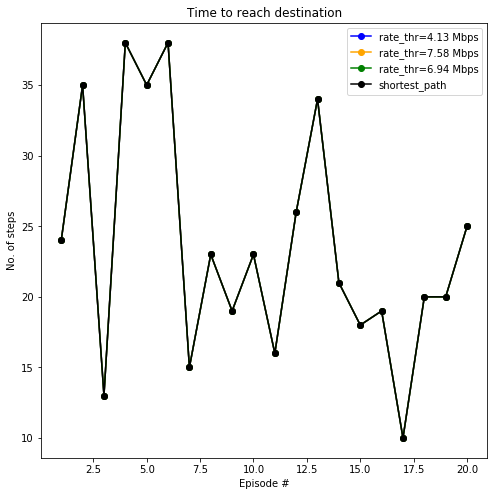

In [16]:
print(model_ep_ue_paths[0][1])
print(model_ep_ue_paths[1][1])
#print(model_ep_ue_path_rates[0][0])
#print(model_ep_ue_path_rates[1][0])
#print(model_ep_tsteps)
#Plot the graph in the end
x_axis = list(np.arange(1, TEST_EPISODES+1))
fig = plt.figure(figsize=(8,8))
plt.plot(x_axis, model_ep_tsteps[0], 'o-', color='blue', label='rate_thr={:.2f} Mbps'.format(10*rate_arr[50]))

plt.plot(x_axis, model_ep_tsteps[1], 'o-', color='orange', label='rate_thr={:.2f} Mbps'.format(10*rate_arr[120]))

plt.plot(x_axis, model_ep_tsteps[2], 'o-', color='green', label='rate_thr={:.2f} Mbps'.format(10*rate_arr[180]))

plt.plot(x_axis, model_ep_tsteps[3], 'o-', color='black', label='shortest_path')

plt.title('Time to reach destination')
plt.xlabel('Episode #')
plt.ylabel('No. of steps')
plt.legend()
plt.show()


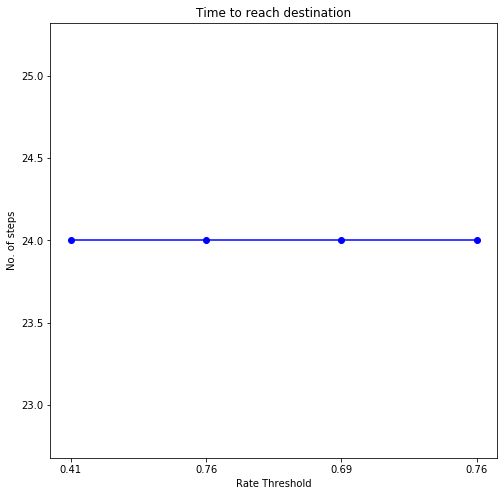

In [17]:
#no. of steps vs rate threshold between same source and destination
x_axis = list(np.arange(1, len(models)+1))
y_axis = [model_ep_tsteps[i][0] for i in range(0,len(model_ep_tsteps))]

fig = plt.figure(figsize=(8,8))
plt.plot(x_axis, y_axis, 'o-', color='blue')

plt.title('Time to reach destination')
plt.xlabel('Rate Threshold')
plt.ylabel('No. of steps')
plt.xticks(np.array(x_axis), [str(np.around(1*rate_arr[x], decimals=2)) for x in [50,120,180,120]])
plt.show()

## 4. Performance Score vs rate threshold, Efficiceny score vs rate threshold (over episode #)

rate_threshold:  0.435




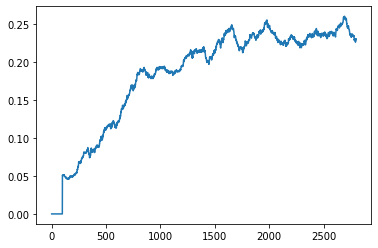

rate_threshold:  0.519




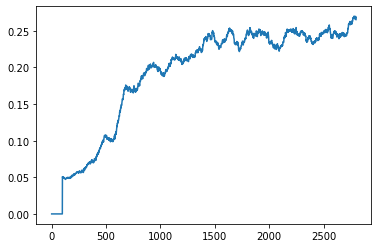

rate_threshold:  0.721




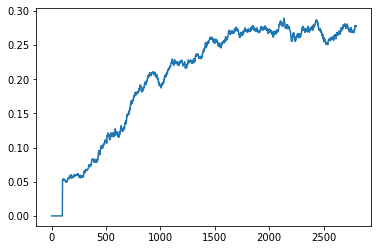

rate_threshold:  0.893




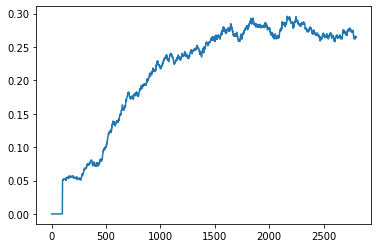

rate_threshold:  1.042


Episode 2800	 timestep: 26, Score: 5.75, eps: 0.010010561361234933



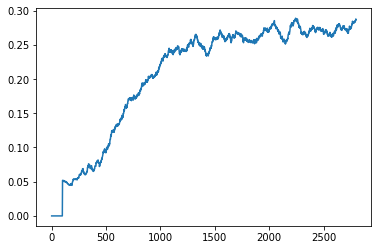

rate_threshold:  0.833


Episode 2800	 timestep: 15, Score: 5.42, eps: 0.010010561361234933



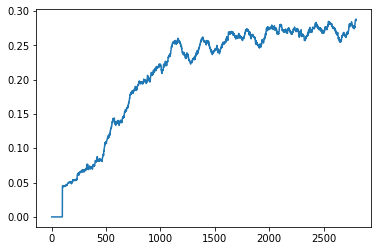

In [18]:
rate_thr_indices = [24, 175, 80, 157, 179, 284]
rate_thr_rwd_fname = 'rate_thr_rewards.txt'
rate_thr_dur_fname = 'rate_thr_durations.txt'
measure = 'rate_thr_path'

rate_thr_episode_rewards = []
rate_thr_episode_durations = []
for rate_ndx in rate_thr_indices:
    print("rate_threshold: ", rate_arr[rate_ndx])
    
    #Re-Initialize Setup
    em, strategy, agent, memory, policy_net, target_net, optimizer = Initialize_Setup()
    rate_thr = rate_arr[rate_ndx]
    
    rate_thr_fname = 'model_' + measure + '_150120_' + str(rate_ndx) + '.pth'
    if os.path.exists(rate_thr_fname):
        episode_rewards = np.loadtxt(measure + '_rewards_150120_' + str(rate_ndx) + '.txt')
        episode_durations = np.loadtxt(measure + '_durations_150120_' + str(rate_ndx) + '.txt')
        episode_rewards = episode_rewards.tolist()
        episode_durations = episode_durations.tolist()
    else:
        #Training Loop
        episode_rewards, episode_durations = Training_Loop(policy_net, target_net, memory,em, agent, optimizer, TRAIN_EPISODES, rate_thr, rate_ndx, measure)

    print("\n")
    rate_thr_episode_rewards.append(episode_rewards)
    rate_thr_episode_durations.append(episode_durations)
    moving_avg = get_moving_average(100, episode_rewards)
    plt.plot(moving_avg)
    plt.show()

np.savetxt(rate_thr_rwd_fname, np.array(rate_thr_episode_rewards), fmt='%f')
np.savetxt(rate_thr_dur_fname, np.array(rate_thr_episode_durations), fmt='%f')


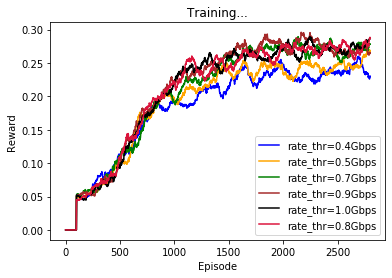

In [19]:
#Plot the figures
plt.figure()
plt.clf()
plt.title('Training...')
plt.xlabel('Episode')
plt.ylabel('Reward')
moving_avg_period = 100

moving_avg0 = get_moving_average(moving_avg_period, rate_thr_episode_rewards[0])
plt.plot(moving_avg0, color='blue', label='rate_thr={0}Gbps'.format(np.around(rate_arr[rate_thr_indices[0]], decimals=1)))

moving_avg1 = get_moving_average(moving_avg_period, rate_thr_episode_rewards[1])
plt.plot(moving_avg1, color='orange', label='rate_thr={0}Gbps'.format(np.around(rate_arr[rate_thr_indices[1]], decimals=1)))


moving_avg2 = get_moving_average(moving_avg_period, rate_thr_episode_rewards[2])
plt.plot(moving_avg2, color='green', label='rate_thr={0}Gbps'.format(np.around(rate_arr[rate_thr_indices[2]], decimals=1)))

moving_avg3 = get_moving_average(moving_avg_period, rate_thr_episode_rewards[3])
plt.plot(moving_avg3, color='brown', label='rate_thr={0}Gbps'.format(np.around(rate_arr[rate_thr_indices[3]], decimals=1)))

moving_avg4 = get_moving_average(moving_avg_period, rate_thr_episode_rewards[4])
plt.plot(moving_avg4, color='black', label='rate_thr={0}Gbps'.format(np.around(rate_arr[rate_thr_indices[4]], decimals=1)))

moving_avg5 = get_moving_average(moving_avg_period, rate_thr_episode_rewards[5])
plt.plot(moving_avg5, color='crimson', label='rate_thr={0}Gbps'.format(np.around(rate_arr[rate_thr_indices[5]], decimals=1)))

plt.legend()
plt.show()

In [20]:
#This cell is mainly to compute the episode paths and rates along the path for different rate threshold methods

measures=['rate_thr_path']

TEST_EPISODES = 40
rate_thr_indices = [175, 80, 284, 157, 179]
#Initialize the setup
em, strategy, agent, memory, policy_net, target_net, optimizer = Initialize_Setup()  

models =['model_rate_thr_path_150120_{}.pth'.format(x) for x in rate_thr_indices]


model_ep_tsteps = []
model_ep_ue_paths=[]
model_ep_ue_path_rates = []
model_ep_ue_exh_rates = []
#get the 3 models with rate_thr approach, get the model with short_path_approach
#.... compare the number of steps over different episodes
state_indices_list = []
for episode in range(TEST_EPISODES):
    state_indices = em.env.obs_space.sample()
    state_indices_list.append(state_indices)
print(state_indices_list)

for model in models:
    #Load the weights from file
    print('Loading {} ...'.format(model))
    policy_net.load_state_dict(torch.load(model))
    policy_net.eval()

    #identify measure id and rate_thr
    meas_id = model.split('_')[1]
    rate_thr = rate_arr[int(model.split('_')[-1].split('.')[0])]
    
    model_tsteps=[]
    model_ue_paths =[]
    model_ue_path_rates =[]
    model_ue_exh_rates = []
    for state_indices in state_indices_list:
    
        #Env Reset based on measure id
        if(meas_id =='short'):
            state_tensor = em.reset(rate_thr, 'short_path', state_indices)
        else:
            state_tensor = em.reset(rate_thr, 'rate_thr_path', state_indices)
        
        step_count = 0
        exh_rates = []
        #Run Episode with the model
        for t_step in count():
            action = policy_net(state_tensor).argmax(dim=1).to(device)
            next_state_tensor, reward, done, _ = em.step(action)
            
            state = np.rint(state_tensor.squeeze().cpu().data.numpy() * em.env.high_obs)
            next_state = np.rint(next_state_tensor.squeeze().cpu().data.numpy() * em.env.high_obs)
            
            curr_loc = (state[0], state[1])
            next_loc = (next_state[0], next_state[1])
            
            next_state = next_state / em.env.high_obs
            state = state / em.env.high_obs
            state_tensor = torch.tensor(np.array([next_state]), dtype=torch.float32).to(device)
            
            step_count+=1
            _,exh_rate = em.env.get_Exh_Rate(next_state)
            
            exh_rates.append(exh_rate)
            if (t_step == EPISODE_STEP_LIMIT) or done:
                model_tsteps.append(step_count)
                print("rate_thr: {}, measure id: {}, count: {}".format(rate_thr, meas_id, step_count))
                model_ue_paths.append(em.env.ue_path)
                model_ue_path_rates.append(em.env.ue_path_rates)
                model_ue_exh_rates.append(exh_rates)
                break
    
    #Collect ep tsteps of each model
    model_ep_tsteps.append(model_tsteps)
    model_ep_ue_paths.append(model_ue_paths)
    model_ep_ue_path_rates.append(model_ue_path_rates)
    model_ep_ue_exh_rates.append(model_ue_exh_rates)
    
    print("\n\n")
    

[array([ 8, 13], dtype=int64), array([10,  7], dtype=int64), array([ 3, 12], dtype=int64), array([6, 5], dtype=int64), array([19,  4], dtype=int64), array([13, 14], dtype=int64), array([9, 3], dtype=int64), array([ 1, 20], dtype=int64), array([16,  0], dtype=int64), array([ 0, 10], dtype=int64), array([ 8, 14], dtype=int64), array([11,  1], dtype=int64), array([12, 11], dtype=int64), array([7, 9], dtype=int64), array([7, 0], dtype=int64), array([4, 0], dtype=int64), array([18,  8], dtype=int64), array([14,  2], dtype=int64), array([13, 15], dtype=int64), array([18,  4], dtype=int64), array([6, 9], dtype=int64), array([4, 5], dtype=int64), array([13, 17], dtype=int64), array([9, 8], dtype=int64), array([9, 7], dtype=int64), array([10, 14], dtype=int64), array([ 7, 13], dtype=int64), array([6, 4], dtype=int64), array([1, 5], dtype=int64), array([5, 6], dtype=int64), array([19,  5], dtype=int64), array([17, 14], dtype=int64), array([20,  1], dtype=int64), array([2, 5], dtype=int64), array

rate_thr: 0.893, measure id: rate, count: 32
rate_thr: 0.893, measure id: rate, count: 22
rate_thr: 0.893, measure id: rate, count: 8
rate_thr: 0.893, measure id: rate, count: 30
rate_thr: 0.893, measure id: rate, count: 31
rate_thr: 0.893, measure id: rate, count: 14
rate_thr: 0.893, measure id: rate, count: 21
rate_thr: 0.893, measure id: rate, count: 23
rate_thr: 0.893, measure id: rate, count: 26



Loading model_rate_thr_path_150120_179.pth ...
rate_thr: 1.042, measure id: rate, count: 22
rate_thr: 1.042, measure id: rate, count: 18
rate_thr: 1.042, measure id: rate, count: 16
rate_thr: 1.042, measure id: rate, count: 12
rate_thr: 1.042, measure id: rate, count: 24
rate_thr: 1.042, measure id: rate, count: 28
rate_thr: 1.042, measure id: rate, count: 13
rate_thr: 1.042, measure id: rate, count: 22
rate_thr: 1.042, measure id: rate, count: 17
rate_thr: 1.042, measure id: rate, count: 11
rate_thr: 1.042, measure id: rate, count: 23
rate_thr: 1.042, measure id: rate, count: 13
rate_t

In [21]:
#print(rate_arr[rate_thr_indices[0]])
#print(model_ep_ue_path_rates)
a1 = np.around(model_ep_ue_path_rates[1][0][:], decimals=3)
a2 = np.around([x/0.9917 for x in model_ep_ue_exh_rates[1][0][:]], decimals=3)
print((np.sum(a1)/np.sum(a2))*64)

#print(model_ep_ue_exh_rates)
#print(em.env.N_rx)


51.936759975361035


55.0


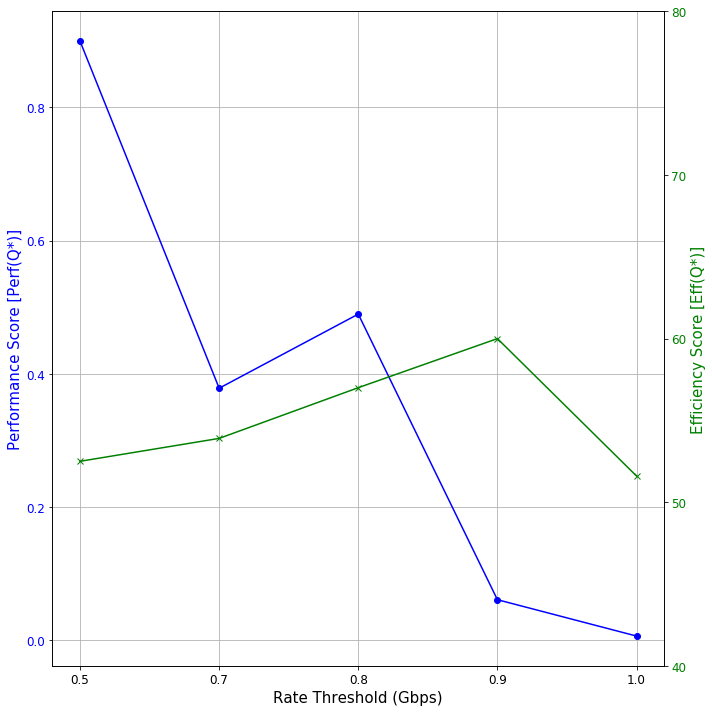

In [22]:
model_perf_scores = []
model_eff_scores = []
for model_ndx in range(len(model_ep_ue_path_rates)):
    ep_perf_scores = []
    ep_eff_scores = []
    for ep_ndx in range(len(model_ep_ue_path_rates[model_ndx])):
        model_score, exh_score = 0,0
        perf_score = 0.0
        eff_score = 0.0
        for rate_ndx in range(len(model_ep_ue_path_rates[model_ndx][ep_ndx])):
            if model_ep_ue_path_rates[model_ndx][ep_ndx][rate_ndx] >= np.around(rate_arr[rate_thr_indices[model_ndx]], decimals=1):
                model_score += 1
            if model_ep_ue_exh_rates[model_ndx][ep_ndx][rate_ndx] >= rate_arr[rate_thr_indices[model_ndx]]:
                exh_score += 1
        #Compute Efficiency Score
        #if (model_ep_ue_exh_rates[model_ndx][ep_ndx][rate_ndx] > 0):
        a1 = (np.around(np.sum(model_ep_ue_path_rates[model_ndx][ep_ndx][:]), decimals=7))
        a2 = np.around(np.sum(model_ep_ue_exh_rates[model_ndx][ep_ndx][:]),decimals=7)
        eff_score = a1*(em.env.N_rx* em.env.N_tx)/a2
        #Compute performance score
        if exh_score > 0:
            perf_score = float(model_score)/float(exh_score)
        ep_perf_scores.append(perf_score)
        ep_eff_scores.append(eff_score)
        
        
    model_perf_scores.append(ep_perf_scores)
    model_eff_scores.append(ep_eff_scores)
    

x_axis = list(np.arange(1, len(rate_thr_indices)+1))
model_mean_perf_scores = [np.mean(x) for x in model_perf_scores]
model_mean_eff_scores = [np.around(np.mean(x),decimals=1) for x in model_eff_scores]
print(np.mean(model_mean_eff_scores))
#fig = plt.figure(figsize=(8,8))

fig, ax1 = plt.subplots(figsize=(10,10))
#ax1.set_title('Performance and Efficiency', fontsize=15)
ax1.set_xlabel('Rate Threshold (Gbps)', fontsize=15)
ax1.set_ylabel('Performance Score [Perf(Q*)]', color='blue', fontsize=15)
ax1.plot(x_axis, model_mean_perf_scores, 'o-', color='blue')
ax1.tick_params(axis='y', labelcolor='blue', labelsize=12)
ax1.tick_params(axis='x', labelsize=12)
ax1.grid()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('Efficiency Score [Eff(Q*)]', color='green', fontsize=15)  # we already handled the x-label with ax1
ax2.plot(x_axis, model_mean_eff_scores, 'x-', color='green')
ax2.tick_params(axis='y', labelcolor='green', labelsize=12)
ax2.set_yticks(np.array(range(40,90,10)))

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.xticks(np.array(x_axis), [str(np.around(rate_arr[x], decimals=1)) for x in rate_thr_indices])
#plt.savefig('eff_perf_scores_051119.pdf')
plt.show()


## 5. Plot rate vs distance (Testing phase)

In [23]:
#plot average cumrate vs UAV distance plot over 'multiple learnt models'
from Source.MIMO import plotbeam

meas='rate_thr_path'
rate_thr_indices = [24, 175,80, 157]#, 175, 280, 179, 262]
rate_thr = [0.435,0.519, 0.721, 0.893, 0.519]

#Initialize the setup
em, strategy, agent, memory, policy_net, target_net, optimizer = Initialize_Setup()
# select source
src_xndx, src_yndx = (19,19) #corresponds to [300,300] location on grid #em.env.obs_space.sample()

models =['model_rate_thr_path_150120_{}.pth'.format(x) for x in rate_thr_indices]
models.append('model_short_path_150120_175.pth')
src_loc = np.array([em.env.ue_xloc[src_xndx],em.env.ue_yloc[src_yndx]])
dest_loc = np.array([em.env.ue_xdest[0], em.env.ue_ydest[0]])
gNB_loc = np.array([em.env.gNB[0][0], em.env.gNB[0][1]]) #2D location

model_ue_dist = []
ue_paths = []
ue_path_rates = []
ue_path_exh_rates = []
ue_short_path_rates = []
ue_short_dist = []
#Run the episode for each model
for i in range(len(models)):
    #Initialize the setup
    em, strategy, agent, memory, policy_net, target_net, optimizer = Initialize_Setup()
    
    #Load the weights from file
    policy_net.load_state_dict(torch.load(models[i]))
    policy_net.eval()

    if models[i].split('_')[1] == 'short':
        meas =  'short_path'
    else:
        meas = 'rate_thr_path'
        
    state_tensor = em.reset(rate_thr[i], meas, (src_xndx, src_yndx))
    ue_dist=[]
    exh_rates = []
    for t_step in count():
        #if (meas == 'short_path'):
        #    action = torch.tensor([random.randrange(agent.action_size)]).to(device)
        #else:
        action = policy_net(state_tensor).argmax(dim=1).to(device)
        next_state_tensor, reward, done, _ = em.step(action)
        
        state = np.rint(state_tensor.squeeze().cpu().data.numpy() * em.env.high_obs)
        next_state = np.rint(next_state_tensor.squeeze().cpu().data.numpy() * em.env.high_obs)
        #print("Current State: ", state)
        #print("Next State: ", next_state)
        learnt_beam_ndx, _ = em.env.decode_action(action)
        learnt_beam_dir = em.env.BeamSet[learnt_beam_ndx]
        
        curr_loc = (state[0], state[1])
        next_loc = (next_state[0], next_state[1])
        temp = np.array([next_state[0], next_state[1]]) - dest_loc
        dist = np.sqrt(temp[0]**2 + temp[1]**2)
        if(meas == 'short_path'):
            ue_short_dist.append(dist)
        else:
            ue_dist.append(dist)
    
        next_state = next_state / em.env.high_obs
        state = state / em.env.high_obs
        
        state_tensor = torch.tensor(np.array([next_state]), dtype=torch.float32).to(device)
        exh_beam_dir, exh_rate = em.env.get_Exh_Rate(next_state)
        
        exh_rates.append(exh_rate)
        if (i==0):
            print("learnt dir: {0}, learnt_rate: {1}, exh_dir: {2}, exh_rate: {3}".format(learnt_beam_dir, em.env.get_Rate(), exh_beam_dir, exh_rate))
            #plotbeam(learnt_beam_dir, 8)
            #plotbeam(exh_beam_dir, 8)
            
        if (t_step == EPISODE_STEP_LIMIT) or done:
            break
    ue_paths.append(em.env.ue_path)
    if(meas == 'short_path'):
        ue_short_path_rates.append(em.env.ue_path_rates)
    else:
        ue_path_rates.append(em.env.ue_path_rates)
        model_ue_dist.append(ue_dist)
    ue_path_exh_rates.append(exh_rates)
    

learnt dir: 2.748893571891069, learnt_rate: 0.29458537840581517, exh_dir: 0.7853981633974483, exh_rate: 0.4698791530699176
learnt dir: 2.748893571891069, learnt_rate: 0.092833916721306, exh_dir: 0.7853981633974483, exh_rate: 0.4131441108641608
learnt dir: 0.7853981633974483, learnt_rate: 0.606701123195956, exh_dir: 0.7853981633974483, exh_rate: 0.5540644104055138
learnt dir: 0.7853981633974483, learnt_rate: 0.3758445133889199, exh_dir: 0.7853981633974483, exh_rate: 0.5430152764540483
learnt dir: 2.748893571891069, learnt_rate: 0.22337004312617167, exh_dir: 0.7853981633974483, exh_rate: 0.4667697126026276
learnt dir: 0.7853981633974483, learnt_rate: 0.5370289858528853, exh_dir: 0.7853981633974483, exh_rate: 0.48093153384825565
learnt dir: 2.748893571891069, learnt_rate: 0.2040041594376974, exh_dir: 0.7853981633974483, exh_rate: 0.7910857035676724
learnt dir: 0.7853981633974483, learnt_rate: 0.6551468175735343, exh_dir: 0.7853981633974483, exh_rate: 0.6095214389371891
learnt dir: 2.74889

In [24]:
#print(src_loc)
#print(dest_loc)
#print(model_ue_dist)
#print(np.cumsum(ue_path_rates[0]))
#print(ue_paths[0])
#print(ue_short_dist)
#print(ue_short_path_rates)
#print(ue_path_exh_rates)
#print(ue_paths[0])
#print(ue_paths[1])
print(model_ue_dist[0][:])
print(ue_path_rates[0][:])
print(ue_path_exh_rates[0][:])

[1308.62523283024, 1274.7548783981963, 1237.9418403139948, 1202.0815280171307, 1167.2617529928752, 1131.370849898476, 1096.5856099730654, 1060.6601717798212, 1025.9142264341594, 992.4716620639604, 960.4686356149273, 930.0537618869137, 901.3878188659974, 874.642784226795, 850.0, 827.6472678623425, 807.7747210701756, 761.5773105863908, 743.3034373659252, 728.0109889280518, 715.8910531638177, 707.1067811865476, 701.78344238091, 700.0, 650.0, 600.0, 550.0, 500.0, 450.0, 400.0, 350.0, 300.0, 250.0, 200.0, 150.0, 100.0, 50.0, 0.0, 0.0]
[0.29458537840581517, 0.092833916721306, 0.606701123195956, 0.3758445133889199, 0.22337004312617167, 0.5370289858528853, 0.2040041594376974, 0.6551468175735343, 0.34288037184213715, 0.19644397600028182, 0.01458312095620041, 0.2583234814677183, 0.20723451296820755, 0.1314811192509163, 0.24864177496193965, 0.43638170897161765, 0.4643979889514626, 0.686922698293212, 0.6178102482026501, 0.46457360721037466, 0.42732601029587114, 0.6635070422811045, 0.69314927117700

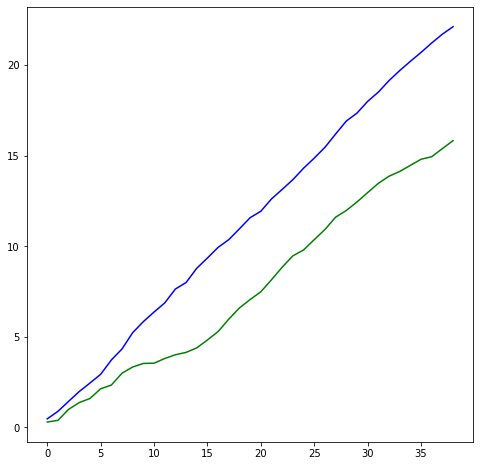

In [25]:
plt.figure(figsize=(8,8))
plt.clf()
plt.plot(np.cumsum(ue_path_exh_rates[0][:]), color='blue')
plt.plot(np.cumsum(ue_path_rates[0][:]), color='green')
plt.show()

[autoreload of gym_uav failed: Traceback (most recent call last):
  File "D:\Phd\PyCharm_workspace\Drone_RL\venv\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "D:\Phd\PyCharm_workspace\Drone_RL\venv\lib\site-packages\IPython\extensions\autoreload.py", line 434, in superreload
    module = reload(module)
  File "D:\Anaconda3\envs\python36\lib\imp.py", line 315, in reload
    return importlib.reload(module)
  File "D:\Anaconda3\envs\python36\lib\importlib\__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "D:\Phd\PyCharm_workspace\Drone_RL\gym_uav\__init__.py", line 5, in <module>
    entry_point='gym_uav.envs:UAV_Env',
  File "D:\Phd\PyCharm_workspace\Drone_RL\venv\lib\site-pac

[1308.62523283 1274.7548784  1240.63010333 1207.60840513 1175.78216574
 1140.87757277 1107.11054665 1073.79989102 1035.52653612  998.28133076
  967.29048017  930.89689688  895.78864613  862.11487641  828.00066772
  796.56573435  764.79386527  725.26362432  696.22194736  669.5452788
  645.51553825  624.43238672  606.60581038  584.43266259  554.81940518
  507.18508151  460.10435823  420.5257702   383.1385637   344.15184401
  296.17216024  259.51925781  212.14428168  166.51174642  124.53559925
   90.23689271   50.            0.        ]
[0.31193008 0.1729466  0.43227691 0.35512902 0.39141157 0.33118884
 0.18808188 0.41293896 0.42246573 0.2754613  0.39096902 0.43607902
 0.53668946 0.564379   0.62775568 0.7068577  0.70196668 0.86336588
 0.73464522 0.65978147 0.5368642  0.58468288 0.62744939 0.62389268
 0.39564638 0.61214165 0.5943214  0.60469721 0.52552857 0.50690405
 0.43666979 0.42453132 0.40816257 0.34973156 0.34931714 0.43766411
 0.37502037 0.49234575]
39 39


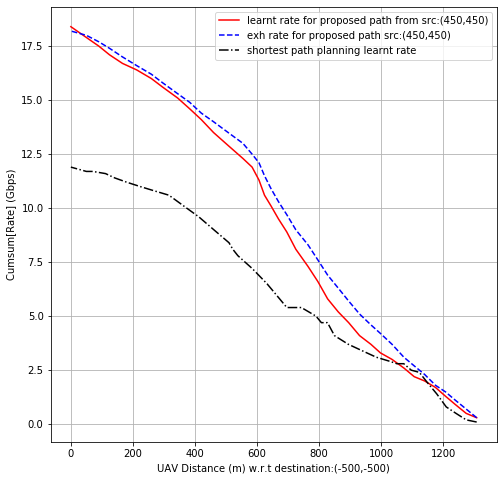

In [28]:
#plot average cumrate vs UAV distance plot over 'multiple learnt models'
avg_ue_path_rates = []
avg_ue_path_exh_rates = []
avg_model_ue_dist = []
for i in range(len(ue_path_rates[0])):
    temp = 0.0
    temp_exh = 0.0
    temp_model_ue_dist = 0.0
    for j in range(len(ue_path_rates)-1):
        temp += ue_path_rates[j][i]
        temp_exh += ue_path_exh_rates[j][i]
        temp_model_ue_dist += model_ue_dist[j][i]
    avg_ue_path_rates.append(temp/(len(ue_path_rates)-1))
    avg_ue_path_exh_rates.append(temp_exh/(len(ue_path_exh_rates)-1))
    avg_model_ue_dist.append(temp_model_ue_dist / (len(model_ue_dist)-1))


plt.figure(figsize=(8,8))
plt.clf()
plt.xlabel('UAV Distance (m) w.r.t destination:({0},{1})'.format(dest_loc[0],dest_loc[1]))
plt.ylabel('Cumsum[Rate] (Gbps)')

colors = ['blue','red','green']


exh_rate_change = np.array(avg_ue_path_exh_rates[:-1])
short_rate_change = np.array(ue_short_path_rates[0][:-1])
avg_model_ue_dist = np.array(avg_model_ue_dist[:-1])
#for i in range(len(models)-1):
learnt_rate_change = np.array(avg_ue_path_rates[:-1])    

print(avg_model_ue_dist)
print(learnt_rate_change)
print(len(model_ue_dist[0]), len(ue_path_rates[0]))

plt.plot(np.around(avg_model_ue_dist, decimals=1), np.around(np.cumsum(learnt_rate_change), decimals=1), label='learnt rate for proposed path from src:({0},{1})'.format(src_loc[0],src_loc[1]), color=colors[1])
plt.plot(np.around(avg_model_ue_dist, decimals=1), np.around(np.cumsum(exh_rate_change), decimals=1), '--', color=colors[0], label='exh rate for proposed path src:({0},{1})'.format(src_loc[0],src_loc[1]))
plt.plot(np.around(ue_short_dist[:-1], decimals=1), np.around(np.cumsum(short_rate_change), decimals=1), '-.', color='black', label='shortest path planning learnt rate')
#plt.plot(ue_path_rates[i])
plt.grid()
plt.legend()
#plt.savefig('cumrate_distance_plot_140120.pdf')
plt.show()

IndexError: list index out of range

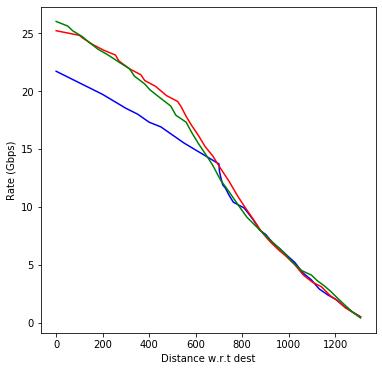

In [27]:
#Plot the exh_rate figures
plt.figure(figsize=(6,6))
plt.clf()
plt.xlabel('Distance w.r.t dest')
plt.ylabel('Rate (Gbps)')

colors = ['blue','red','green']
for i in range(len(models)-1):
    plt.plot(np.around(model_ue_dist[i][:-1], decimals=1), np.around(np.cumsum(ue_path_exh_rates[i][:-1]), decimals=1), color=colors[i], label='rate_thr={0}Gbps'.format(np.around(rate_thr[i], decimals=1)))
plt.grid()
plt.legend()
#plt.savefig('rate_distance_plot_301019.pdf')
plt.show()

In [ ]:
#Plot the figures
plt.figure(figsize=(8,8))
plt.clf()
plt.xlabel('UAV Distance (m) w.r.t destination:({0},{1})'.format(dest_loc[0],dest_loc[1]))
plt.ylabel('CumSum \u0394Rate (Gbps)')

colors = ['blue','red','green']
i=1

exh_rate_change = np.array(ue_path_exh_rates[i][:-1])-rate_thr[i]
short_rate_change = np.array(ue_short_path_rates[0][:-1])-rate_thr[i]
#for i in range(len(models)-1):
learnt_rate_change = np.array(ue_path_rates[i][:-1])-rate_thr[i]    
plt.plot(np.around(model_ue_dist[i][:-1], decimals=1), np.around(np.cumsum(learnt_rate_change), decimals=1), label='learnt rate for proposed path rate_thr={0} Gbps'.format(np.around(rate_thr[i], decimals=1)), color=colors[i])
plt.plot(np.around(model_ue_dist[i][:-1], decimals=1), np.around(np.cumsum(exh_rate_change), decimals=1), '--', color=colors[0], label='exh rate for proposed path rate_thr={0} Gbps'.format(np.around(rate_thr[i], decimals=1)))
plt.plot(np.around(ue_short_dist[:-1], decimals=1), np.around(np.cumsum(short_rate_change), decimals=1), '-.', color='black', label='shortest path planning learnt rate')
#plt.plot(ue_path_rates[i])
plt.grid()
plt.legend()
#plt.savefig('rate_change_distance_plot_051119.pdf')
plt.show()

In [ ]:
#Plot the figures
plt.figure(figsize=(8,8))
plt.clf()
plt.xlabel('UAV Distance (m) w.r.t destination:({0},{1})'.format(dest_loc[0],dest_loc[1]))
plt.ylabel('Cumsum[Rate] (Gbps)')

colors = ['blue','red','green']
i=1

exh_rate_change = np.array(ue_path_exh_rates[i][:-1])
short_rate_change = np.array(ue_short_path_rates[0][:-1])
#for i in range(len(models)-1):
learnt_rate_change = np.array(ue_path_rates[i][:-1])    
plt.plot(np.around(model_ue_dist[i][:-1], decimals=1), np.around(np.cumsum(learnt_rate_change), decimals=1), label='learnt rate for proposed path rate_thr={0} Gbps'.format(np.around(rate_thr[i], decimals=1)), color=colors[i])
plt.plot(np.around(model_ue_dist[i][:-1], decimals=1), np.around(np.cumsum(exh_rate_change), decimals=1), '--', color=colors[0], label='exh rate for proposed path rate_thr={0} Gbps'.format(np.around(rate_thr[i], decimals=1)))
plt.plot(np.around(ue_short_dist[:-1], decimals=1), np.around(np.cumsum(short_rate_change), decimals=1), '-.', color='black', label='shortest path planning learnt rate')
#plt.plot(ue_path_rates[i])
plt.grid()
plt.legend()
#plt.savefig('rate_distance_plot_051119.pdf')
plt.show()

In [ ]:
i=1
learnt_cumrates = np.cumsum(np.array(ue_path_rates[i][:-1]))
exh_cumrates = np.cumsum(np.array(ue_path_exh_rates[i][:-1]))
x = [np.sqrt(loc[0]**2+loc[1]**2) for loc in ue_paths[1]][:-1]
y1 = [learnt_cumrates[0]]
y2 = [exh_cumrates[0]]
for j in range(0,len(learnt_cumrates)-1):
    #print(learnt_cumrates[i+1]-learnt_cumrates[i])
    y1.append(np.around(learnt_cumrates[j+1]-learnt_cumrates[j], decimals=1))

plt.figure(figsize=(8,8))
plt.clf()
plt.xlabel('UAV Distance (m) w.r.t destination:({0},{1})'.format(dest_loc[0],dest_loc[1]))
plt.ylabel('Cumsum[Rate] (Gbps)')

plt.plot(np.around(x,decimals=1), y1, label='learnt rate for proposed path rate_thr={0} Gbps'.format(np.around(0.519, decimals=1)), color='blue')
#plt.plot(np.around(model_ue_dist[1][:-1],decimals=1), y2, label='learnt rate for proposed path rate_thr={0} Gbps'.format(np.around(0.519, decimals=1)), color='red')
plt.show()

In [ ]:
#Plot Average cumrate vs UAV distance plot over 'multiple paths'